In [1]:
#Import modules

import pandas as pd
# from IPython.display import display, HTML
# from numpy import log10, nan, inf, random, clip, arange

# path = './../export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

# display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from numpy import arange, log10

from functions import chunk, agg, finalize
tunique = dd.Aggregation('tunique', chunk, agg,finalize)
first = dd.Aggregation('first', chunk, agg,finalize)

### Prices and quantities

In [4]:
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'CN ID 8', u'PYOD', u'VART', u'MASSE', u'USUP', u'USUP_MT']

df_list = []

for y in range(1997, 2005):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'}).fillna('')]

data_ = dd.concat(df_list)
data_.columns = columns

In [5]:
# with ProgressBar():
#     df = data_.compute()

In [6]:
grouped = data_.loc[data_.FLUX == 2].groupby(['ID', 'CN ID 8', 'MONTH', 'YEAR'])

In [12]:
# df = 
# df = df.sort_index().reset_index()

with ProgressBar():
    out = grouped[['VART', 'MASSE']].sum().compute()
out.to_csv('units_bkp.csv')

with ProgressBar():
    out_2 = data_.loc[data_.FLUX == 2].groupby(['ID', 'CN ID 8']).agg(
        {'VART': sum, 'MASSE': sum, 'USUP': tunique, 'USUP': first, 'USUP_MT': sum}).compute()
out_2.to_csv('units_bkp.csv')

[########################################] | 100% Completed |  5min 47.3s


In [8]:
df_ = out.sort_index().reset_index()
# .diff()

NameError: name 'out' is not defined

In [ ]:
dif = df_.diff()

In [ ]:
dif.loc[(dif.ID == 0) & (dif['CN ID 8'] == 0) & (dif['MONTH'] == 0) & (dif.YEAR == 1)]

## Firm sizes

In [182]:
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'VAT', u'VART']

df_list = []

for y in range(1997, 2014):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'})]

data = dd.concat(df_list)
data.columns = columns
data['IMPORT'] = data['FLUX'] % 2


In [183]:
firm_sizes = data.groupby(['ID', 'IMPORT','YEAR'])[['VART']].sum().reset_index()
buyr_sizes = data.groupby(['VAT', 'IMPORT','YEAR'])[['VART']].sum().reset_index()


In [ ]:
with ProgressBar():
    firm_sizes = firm_sizes.compute()
    buyr_sizes = buyr_sizes.compute()
    
firm_sizes['log_VART'] = log10(firm_sizes.VART)
buyr_sizes['log_VART'] = log10(buyr_sizes.VART)

firm_sizes.to_csv('firm_sizes.csv', index = False)
buyr_sizes.to_csv('sell_sizes.csv', index = False)

[############                            ] | 30% Completed |  4min 21.8s

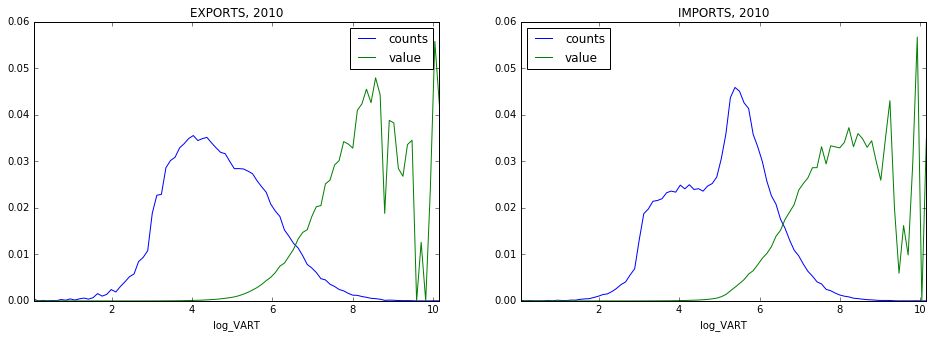

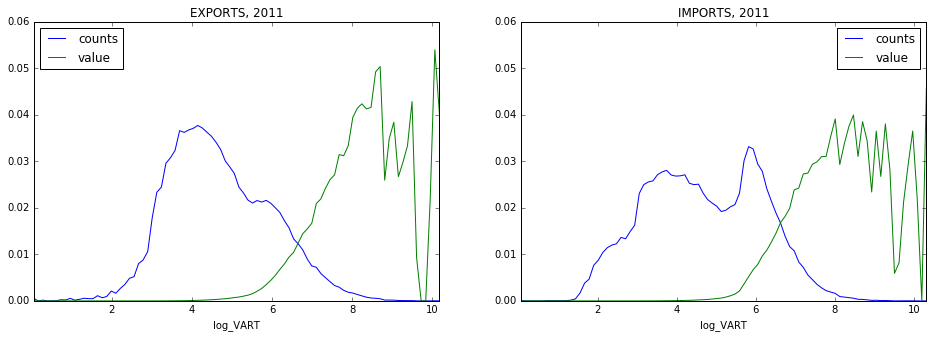

In [117]:
from numpy import inf, nan

for y in [2010, 2011]:
    fig, axs = plt.subplots(1, 2, figsize = (16, 5))
    for i in [0, 1]:
        fs_df_slice = fs_df.loc[(fs_df.YEAR == y) & (fs_df.IMPORT == i)].replace(-inf, nan).dropna()
        fs_df_slice['bin'], bins_x = pd.cut(fs_df_slice['log_VART'], 90, retbins=True)

        fs_ct_val = fs_df_slice.groupby('bin').agg({'ID': 'count', 'VART': sum}).rename(columns = {'ID': 'counts', 'VART': 'value'})

        fs_ct_val/=fs_ct_val.sum()
        ax = axs[i]
        fs_ct_val['log_VART'] = (bins_x[:-1] + bins_x[1:])/2.
        fs_ct_val.plot(x = 'log_VART', y = 'counts', ax = ax)
        fs_ct_val.plot(x = 'log_VART', y = 'value', ax = ax)
        ax.set_title('IMPORTS, '+str(y)) if i == 1 else ax.set_title('EXPORTS, '+str(y))
        ax.set_ylim(0, 0.06)

### Degree distributions and assortativity

In [ ]:
# dd.read_csv('2014-*.csv')

# drive_path = './../export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

n_bins = 20
df_list = n_bins * [ 0 ]

for dataset_i in range(n_bins):
    df_list[dataset_i] = dd.read_csv(drive_path+'/samplings/YMxpb_size20'+str(dataset_i).zfill(2)+'.csv')#,
#                                     usecols = ['YEAR','ID','VAT','VART_sum'])

data = dd.concat(df_list)
data = data.groupby(['YEAR','ID','VAT'])['VART_sum'].sum().reset_index()

In [ ]:
with ProgressBar():
    out = data.compute()
out.to_csv('buyer_seller_links.csv', index = False)

data = dd.from_pandas(out, npartitions = 100)

In [142]:
links = pd.read_csv('./buyer_seller_links.csv')
links = links.loc[links.VART_sum > 1000]
links_count = links.groupby('YEAR').agg({'VART_sum': 'count', 'ID': 'nunique', 'VAT': 'nunique'})
links_count = links_count.rename(columns = {'VART_sum': 'pairs', 'ID': 'FR sellers', 'VAT': 'foreign buyers'})
links_pct_change = 100*links_count.pct_change().round(4).fillna('')

In [143]:
links_summary = pd.concat([links_count,links_pct_change], axis = 1)
links_summary.columns = pd.MultiIndex.from_product([['count', 'yearly pct change'], links_count.columns])

In [144]:
links_summary

count                               yearly D%               \
      # pairs # FR sellers # foreign buyers   # pairs # FR sellers   
YEAR                                                                 
1997   810865        48482           349416                          
1998   853034        53380           356449       5.2         10.1   
1999   879117        54320           367328      3.06         1.76   
2000   900988        54481           381432      2.49          0.3   
2001   887826        50259           384110     -1.46        -7.75   
2002   899477        48530           390763      1.31        -3.44   
2003   899695        48273           397693      0.02        -0.53   
2004   955009        48682           426010      6.15         0.85   
2005   974115        48417           429763         2        -0.54   
2006   980558        46912           434310      0.66        -3.11   
2007  1002149        45967           450843       2.2        -2.01   
2008   985853        45141           447878     -1.63         -1.8   
2009   930321        43192           430183     -5.63        -4.32   
2010   946037        42463           437200      1.69        -1.69   
2011   834748        26690           406142    -11.76       -37.15   
2012   830036        24846           404678     -0.56        -6.91   
2013   829460        24768           403480     -0.07        -0.31   

                       
     # foreign buyers  
YEAR                   
1997                   
1998             2.01  
1999             3.05  
2000             3.84  
2001              0.7  
2002             1.73  
2003             1.77  
2004             7.12  
2005             0.88  
2006             1.06  
2007             3.81  
2008            -0.66  
2009            -3.95  
2010             1.63  
2011             -7.1  
2012            -0.36  
2013             -0.3

In [157]:
# buyer_sizes = links.groupby(['VAT', 'YEAR'])[['VART_sum']].sum()
# buyer_sizes.to_csv('./buyer_sizes.csv')
seller_sizes = links.groupby(['ID', 'YEAR'])[['VART_sum']].sum()
seller_sizes.to_csv('./seller_sizes.csv')

In [173]:
from numpy import true_divide

In [174]:
true_divide(seller_sizes.groupby('YEAR').sum().values,seller_sizes_2.groupby('YEAR').sum().values)

array([[ 0.61679077],
       [ 0.62667167],
       [ 0.62871794],
       [ 0.61166716],
       [ 0.60011988],
       [ 0.6159321 ],
       [ 0.62893016],
       [ 0.65116874],
       [ 0.65510284],
       [ 0.65308385],
       [ 0.65849298],
       [ 0.6418733 ],
       [ 0.6260665 ],
       [ 0.61102505],
       [ 0.6076149 ],
       [ 0.58998636],
       [ 0.59425344]])

In [164]:
pd.concat([seller_sizes, seller_sizes_2], axis = 1)

VART_sum        VART
ID        YEAR                       
0         1997        NaN    39913032
          1998        NaN    25985808
          1999        NaN    44626344
          2000        NaN    15188499
          2001        NaN    60013092
          2002        NaN    16027572
          2003        NaN    10909484
          2004        NaN    17354863
          2005        NaN     8502114
          2006        NaN    14040307
          2007        NaN    14002190
          2008        NaN    51185304
          2009        NaN     9799932
          2010        NaN    97361175
          2011        NaN     1435637
          2012        NaN      131222
          2013        NaN        1109
18        2003        NaN       11563
20        2003        NaN       24396
125       1999        NaN         989
140       1999     1244.0        1244
158       2007        NaN        1085
207       2002    23216.0       23981
215       1997   656617.0      656617
          1998   807502.0      807502
          1999   294997.0      295262
          2000  1258219.0     1258219
          2001  2360520.0     2360520
          2002  2080326.0     2080326
          2003   781414.0      781414
...                   ...         ...
999990740 1999        NaN        1512
999995830 2000        NaN       49981
999999758 2005        NaN    12927802
999999998 1997    85787.0      691678
          1998        NaN      578712
          1999        NaN      496463
          2000        NaN      993375
          2001        NaN      342077
          2002        NaN      195379
          2003        NaN       52395
          2004        NaN       46860
          2006        NaN        5953
          2013        NaN       22468
999999999 1997        NaN   488235486
          1998        NaN   416550018
          1999        NaN   455616874
          2000        NaN   524527127
          2001        NaN   440280381
          2002        NaN   581613514
          2003        NaN   548561587
          2004        NaN   601112371
          2005        NaN   538651677
          2006        NaN   823716999
          2007        NaN   870909068
          2008        NaN   985288658
          2009        NaN   891431035
          2010        NaN  1115108338
          2011        NaN  1713254430
          2012        NaN  1867877360
          2013        NaN  1862296934

[1880825 rows x 2 columns]

In [162]:
seller_sizes_2 = fs_df.loc[fs_df.IMPORT == 0].groupby(['ID', 'YEAR'])[['VART']].sum()

In [126]:
links['log_VART'] = log10(links.VART_sum)#.replace(-inf, nan).dropna()
links['bin'], bins_x = pd.cut(links['log_VART'], 90, retbins=True)
links_y = links.loc[links.YEAR == 2013]

# links['log_VART'] = (bins_x[:-1] + bins_x[1:])/2.

In [150]:
links_y.groupby('VAT')[['VART_sum']].sum()

,VART_sum
VAT,
AT0000079,11293
AT0000535,60617
AT0000536,9366
AT0000542,7083
AT0000553,4278
AT0000558,4231
AT0000563,12506
AT0000566,20395
AT0000578,8544


## Degree distribution and assortativity

In [ ]:
# window = 3
# assortativity_res = []
ID_degree_res = []
VAT_degree_res = []

for window in [3]:
    gap = (window-1)/2
    center_years = arange(2003, 2014, 2)
    print window

    for Yc in center_years:
        print Yc
        data_sec = data.loc[data.YEAR - Yc <= gap]
#         data_sec.groupby(['ID', 'VAT']).agg({'CN ID 8': tunique, 'VART_sum': sum })

        data_sec_by_ID = data_sec.groupby(['ID']).agg({'VAT': tunique, 'VART_sum': sum})

        ID_degree = data_sec_by_ID[['VAT']].reset_index()
        ID_degree.columns = [u'ID', u'ID_degree']
        ID_degree['center_year'] = Yc
        ID_degree['window'] = window
        
        with ProgressBar():
            ID_deg = ID_degree.compute()
            ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
            ID_deg.to_csv('ID_deg_'+str(Yc)+'_'+str(window))
#         ID_degree_res += [ID_degree]     

#         ID_deg = pd.read_csv()
        sampling = ID_deg.groupby(['bin'], observed = True).apply(lambda x: x.sample(200, replace = True))

        data_sec_sample = data_sec.loc[data_sec.ID.isin(sampling['ID'].values)]
        data_sec_by_VAT = data_sec_sample.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})

        VAT_degree = data_sec_by_VAT[['ID']].reset_index()
        VAT_degree.columns = [u'VAT', u'VAT_degree']
        VAT_degree['center_year'] = Yc
        VAT_degree['window'] = window
        VAT_degree_res += [VAT_degree]
        with ProgressBar():
            VAT_deg = VAT_degree.compute()
            VAT_deg.to_csv('VAT_deg_'+str(Yc)+'_'+str(window))

In [ ]:
# VAT_degree_res = []
# for window in [1, 3, 5]:
#     gap = (window-1)/2
#     center_years = arange(1997, 2014, 2)
#     print window

#     for Yc in center_years:
    
#         ID_deg = pd.read_csv('./ID_deg_save.csv')
#         ID_deg = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
#         ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
#         sampling = ID_deg.groupby(['bin'], observed = True).apply(lambda x: x.sample(50, replace = True))

#         data_sec_sample = data_sec.loc[data_sec.ID.isin(sampling['ID'].values)]
#         data_sec_by_VAT = data_sec_sample.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})

#         VAT_degree = data_sec_by_VAT[['ID']].reset_index()
#         VAT_degree.columns = [u'VAT', u'VAT_degree']
#         VAT_degree['center_year'] = Yc
#         VAT_degree['window'] = window
#         VAT_degree_res += [VAT_degree]
#         with ProgressBar():
#             VAT_deg = VAT_degree.compute()
#             VAT_deg.to_csv('VAT_deg_save_'+str(Yc)+'_'+str(window))

# #         assortativity_info = data_sec_sample.groupby(['ID', 'VAT'])[['VART_sum']].mean().reset_index().merge(
# #             ID_degree).merge(VAT_degree)
# #         assortativity_res += [assortativity_info]


In [ ]:
# ID_degree['bin'] = 
# pd.cut(log10(ID_degree['ID_degree']), bins = arange(-.49, 5.99, .5))

In [ ]:
# # ID_deg_res = dd.concat(ID_degree_res)
# # with ProgressBar():
# #     ID_deg = ID_deg_res.compute()

# VAT_deg_res = dd.concat(VAT_degree_res)
# with ProgressBar():
#     VAT_deg = VAT_deg_res.compute()

In [ ]:
# ID_deg.to_csv('./ID_deg_save.csv', index = False)
# VAT_deg.to_csv('./VAT_deg_save.csv', index = False)

In [ ]:
# plt.hist(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
# plt.show()

In [ ]:
# # 
# # data_sec_sample.merge(ID_deg).merge(VAT_deg).compute()
# assortativity_info = data_sec_sample.groupby(['ID', 'VAT'])[['VART_sum']].mean().reset_index().merge(
#         ID_degree).merge(VAT_degree)

In [ ]:

# with ProgressBar():
#     assortativity_df = assortativity_info.compute()

In [ ]:
# assortativity_info.groupby(pd.cut(log10(assortativity_info['ID_degree']), bins = arange(-.49, 5.99, .5)))#['VAT_degree'].describe()

In [ ]:
# ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .5))
# ID_deg.groupby(['center_year','bin'])

In [ ]:
# data_sec_sample

In [ ]:
# # ID_deg.to_csv('degree_values.csv', index = False)

# from numpy import power
# left = power(10, arange(-.1, 5, .2)).round(1)
# right = power(10, arange(-.1, 5, .2) + .2).round(1)
# bins = pd.IntervalIndex.from_arrays(left, right)

# ID_deg_part = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
# ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).count().sort_index()

# sample_IDs = ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).apply(lambda x: x.sample(1000, replace = True))['ID'].values

# data_sec = data.loc[(data.YEAR - Yc <= gap) & (data.ID.isin(sample_IDs))]

    
# #.apply(lambda x: x.sample(5000, replace = True))['ID'].values

In [ ]:
# window = 3
# results = []
    
# gap = (3-1)/2
# center_years = arange(1997, 2014, 2)
# ID_degree_res = []
# VAT_degree_res = []



# for Yc in center_years:
#     VAT_deg_part = VAT_deg.loc[(VAT_deg.center_year == Yc) & (VAT_deg.window == window)]
#     ID_deg_part = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
#     sample_IDs = ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).apply(lambda x: x.sample(1000, replace = True))['ID'].values
    
#     data_sec = data.loc[(data.YEAR - Yc <= gap) & (data.ID.isin(sample_IDs))]

#     df_degrees = data_sec.merge(ID_deg_part, on = 'ID').merge(VAT_deg_part, on = ['VAT', 'center_year', 'window'])

#     results += [df_degrees]


In [ ]:
# summary_results = []

# for df_degrees in results:

#     with ProgressBar():
#         x = df_degrees.compute()

#     summary_result = x.groupby(pd.cut(x['ID_degree'], bins)).agg({'VART_sum': 'sum', 'ID_degree': 'mean',
#                                             'VAT_degree': 'describe', 'center_year' : 'median', 'window': 'median'})
#     summary_results += [summary_result]

In [ ]:
# pd.concat(summary_results).dropna().to_csv('./assortativity_2000_full.csv')

In [ ]:
# pd.concat(summary_results)

In [ ]:
# pd.concat(summary_results).dropna().to_csv('./assortativity_2000_8plus.csv')

In [ ]:
# window = 3
# results = []
    
# gap = (3-1)/2
# center_years = arange(1997, 2014, 2)
# ID_degree_res = []
# VAT_degree_res = []

# for Yc in center_years:
#     data_sec = data.loc[data.YEAR - Yc <= gap]

# #     data_sec.groupby(['ID', 'VAT']).agg({'CN ID 8': tunique, 'VART_sum': sum })

#     data_sec_by_VAT = data_sec.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})
#     data_sec_by_ID = data_sec.groupby(['ID']).agg({'VAT': tunique, 'VART_sum': sum})

#     VAT_degree = data_sec_by_VAT[['ID']].reset_index()
#     VAT_degree.columns = [u'VAT', u'VAT_degree']
#     ID_degree = data_sec_by_ID[['VAT']].reset_index()
#     ID_degree.columns = [u'ID', u'ID_degree']

#     df_degrees = data_sec.merge(ID_degree, on = 'ID').merge(VAT_degree, on = 'VAT')

#     from numpy import power
#     left = power(10, arange(0, 4.5, .1)).round()
#     right = power(10, arange(0, 4.5, .1) + .1).round()
#     bins = pd.IntervalIndex.from_arrays(left, right)

#     df_degrees['ID_degree_bin'] = df_degrees['ID_degree'].map_partitions(pd.cut, bins)
#     df_degrees['VAT_degree_bin'] = df_degrees['VAT_degree'].map_partitions(pd.cut, bins)
    
#     result = df_degrees.groupby('ID_degree_bin')[['ID_degree','VAT_degree']].agg({'ID_degree': 'mean', 'VAT_degree': 'mean'})
#     result.columns = pd.MultiIndex.from_product([result.columns, [str(Yc)], [str(window)]])
#     results += [result]

In [ ]:
# res = dd.concat(results, axis = 1)


# with ProgressBar():
#     out_2 = res.compute()

In [ ]:
# fig, ax = plt.subplots(1)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.25).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.5).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.75).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)

# # df_degrees.groupby('ID_nunique_bin')['VAT_nunique','ID_nunique'].mean().plot(x = 'ID_nunique', y = 'VAT_nunique', marker = 'o', ax = ax)
# df_degrees.groupby('ID_nunique')['VAT_nunique'].median().plot(x = 'index', y = 'VAT_nunique', marker = '.', linewidth = 0, ax = ax)
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
# ### Choose a bin_size, 
# size_df_list = n_size_bins * [ None ]

# for s in range(14, n_size_bins):

#     bs_ix_df = exp_index.loc[exp_index.size_bins == s]

#     size_i_df_list = []
#     for dataset_i in bs_ix_df.exp_mma_cat.unique():
#         df = df_list[dataset_i]
#         size_i_df_list += [df.loc[df.ID.isin(bs_ix_df.ID)]]

#         size_df_list[s] = pd.concat(size_i_df_list)